## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [10]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import yfinance as yf
import pandas as pd


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [11]:
ticker = 'SPLG'

# 데이터 가져오기 (3년치 데이터)
data = yf.download(ticker, start='2019-10-01', end='2024-09-30')

# 데이터 출력
print(data)

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2019-10-01  34.930000  35.020000  34.389999  34.400002  31.742296  2627700
2019-10-02  34.230000  34.230000  33.660000  33.810001  31.197880  1191300
2019-10-03  33.770000  34.099998  33.450001  34.090000  31.456249  1417100
2019-10-04  34.200001  34.590000  34.200001  34.570000  31.899145   581400
2019-10-07  34.490002  34.660000  34.389999  34.410000  31.751511  2644700
...               ...        ...        ...        ...        ...      ...
2024-09-23  66.959999  67.070000  66.809998  67.000000  67.000000  5410600
2024-09-24  67.099998  67.199997  66.760002  67.190002  67.190002  4700100
2024-09-25  67.180000  67.260002  66.910004  67.040001  67.040001  4209200
2024-09-26  67.559998  67.580002  67.029999  67.309998  67.309998  4945600
2024-09-27  67.440002  67.529999  67.089996  67.220001  67.220001  4683100

[1257 rows x 6 columns]


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [10]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [6]:
data.sort_index(inplace = True)

data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-01,34.930000,35.020000,34.389999,34.400002,31.742296,2627700
2019-10-02,34.230000,34.230000,33.660000,33.810001,31.197880,1191300
2019-10-03,33.770000,34.099998,33.450001,34.090000,31.456249,1417100
2019-10-04,34.200001,34.590000,34.200001,34.570000,31.899145,581400
2019-10-07,34.490002,34.660000,34.389999,34.410000,31.751511,2644700
...,...,...,...,...,...,...
2024-09-23,66.959999,67.070000,66.809998,67.000000,67.000000,5410600
2024-09-24,67.099998,67.199997,66.760002,67.190002,67.190002,4700100
2024-09-25,67.180000,67.260002,66.910004,67.040001,67.040001,4209200


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

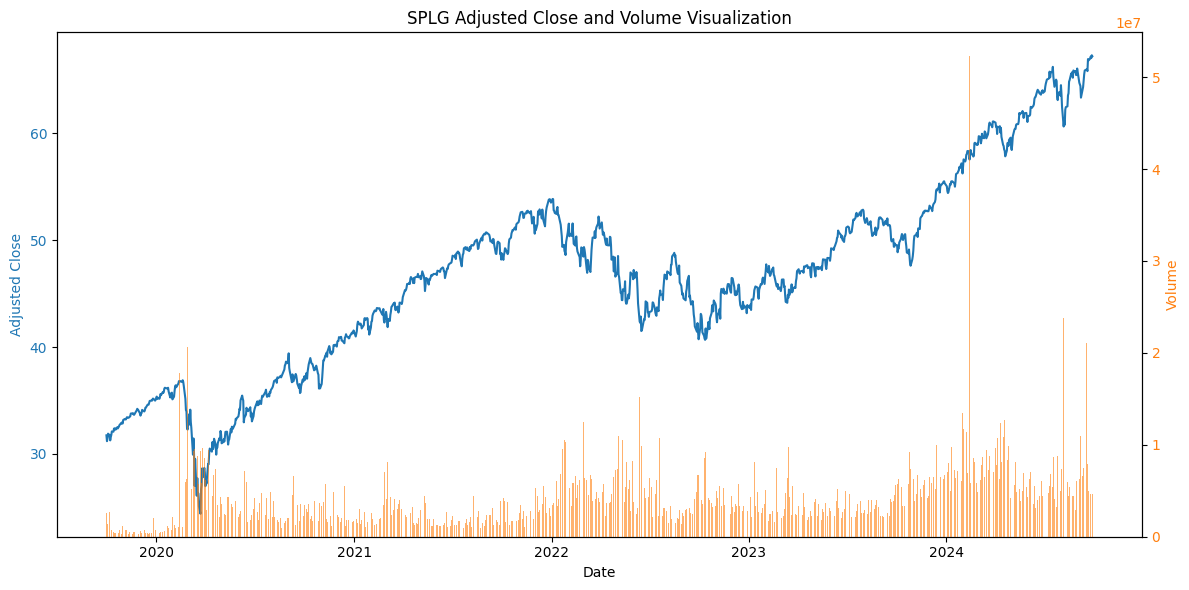

Max Adjusted Close: 67.30999755859375 on 2024-09-26
Min Adjusted Close: 24.40176010131836 on 2020-03-23
Max Volume: 52263600 on 2024-02-13
Min Volume: 245500 on 2019-12-24


In [12]:
## 수정 종가와 거래량 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))

# 수정 종가 시각화
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close', color='tab:blue')
ax1.plot(data.index, data['Adj Close'], color='tab:blue', label='Adjusted Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# 거래량 시각화 (같은 그래프에 추가)
ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.6, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# 그래프 제목 추가 (영어로 변경)
plt.title(f'{ticker} Adjusted Close and Volume Visualization')
fig.tight_layout()
plt.show()

# 최대 및 최소 값 찾기
max_close_date = data['Adj Close'].idxmax()
min_close_date = data['Adj Close'].idxmin()
max_volume_date = data['Volume'].idxmax()
min_volume_date = data['Volume'].idxmin()

# 결과 출력
print(f'Max Adjusted Close: {data["Adj Close"].max()} on {max_close_date.date()}')
print(f'Min Adjusted Close: {data["Adj Close"].min()} on {min_close_date.date()}')
print(f'Max Volume: {data["Volume"].max()} on {max_volume_date.date()}')
print(f'Min Volume: {data["Volume"].min()} on {min_volume_date.date()}')

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

In [16]:
#종가가 가장 낮을때는 2020-03-23로 코로나로 인한 영향이라 생각한다
#종가가 가장 높을때는 2024-09-26으로 최근금리인하의 영향이라 생각한다
#거래량이 가장 많을때는 2024-02-13으로 미국 1월 소비자물가지수(cpi)가 발표되었고 결과 소비자물가지수가 전녀대비 3.1p%상승했고, 금리인하를 기대하던 심리가 무너지며 나스닥시작이 콘폭으로 하락한 영향을 받은것으로 생각된다
# splg는 미국 s&p500을 추종하는 etf로 주가가 미국시장의 영향을 크게 받는것을 알 수 있다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

정상성은 시계열 데이터의 통계적 특성이 시간에 따라 변하지 않은 것을 의미한다. 평균,분산,자기공분산 등이 시간에 관계없이 일정하게 유지되는 상태를 말한다.

비정상성을 해결하기 위한 방법에는
데이터의 분산을 안정화하기 위해 로그 변환을 사용하거나, 시계열 데이터에서 계절성을 분리하여 제거하는 계절성 조정이 있다.

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [14]:
# 수정 종가에 대한 ADF 검정 함수 정의
def adf_test(series):
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Statistic', 'p-value', '# of Lags', '# of Observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

# ADF 테스트 수행
adf_test(data['Adj Close'])

Results of Augmented Dickey-Fuller test:
ADF Statistic             -0.317798
p-value                    0.922946
# of Lags                 10.000000
# of Observations       1246.000000
Critical Value (1%)       -3.435609
Critical Value (5%)       -2.863862
Critical Value (10%)      -2.568006
dtype: float64


2.3 ADF Test 결과를 해석하세요.

adf통계값이 -0.317798
p-value 0.922946로 0.05보다 크므로. 시계일이 비정상적임을 알 수 있다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

ACF: 전 지연에 대한 자기상관을 측정하며, 모든 과거 데이터의 영향을 포함한다

PACF: 특정 지연에 대한 자기상관을 측정하지만, 이전 지연의 영향을 제거하여 순수한 관계를 나타낸다.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

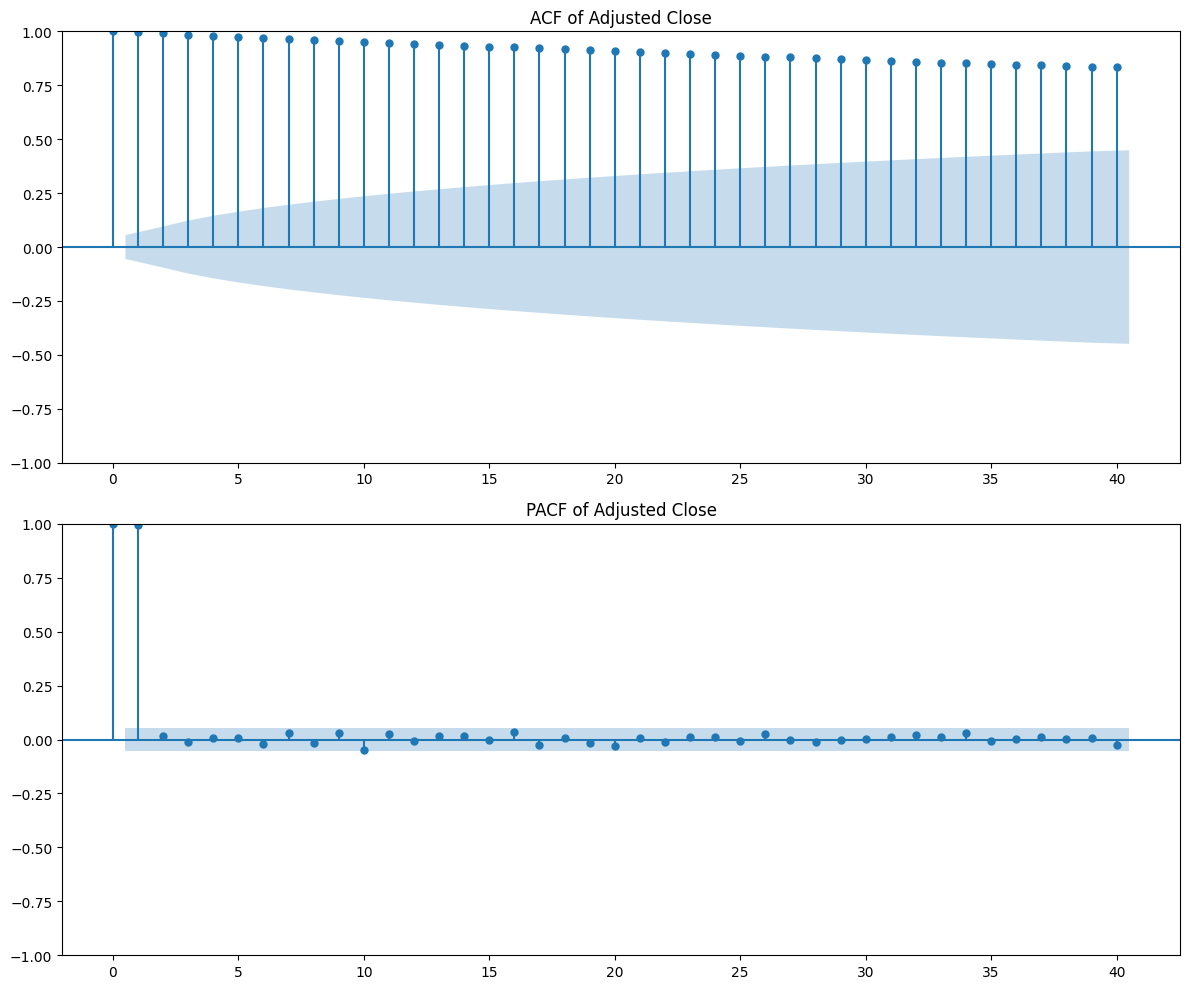

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF와 PACF 그래프 그리기
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# ACF 그래프
plot_acf(data['Adj Close'], lags=40, ax=ax[0])
ax[0].set_title('ACF of Adjusted Close')

# PACF 그래프
plot_pacf(data['Adj Close'], lags=40, ax=ax[1])
ax[1].set_title('PACF of Adjusted Close')

plt.tight_layout()
plt.show()


2.6 결과를 해석하세요.

ACF 그래프에서 처음 몇 개의 지연(lag)에서 자기상관이 비교적 높은 값을 보입니다. 그러나 시간이 지나면서 자기상관이 점차 감소하고 있습니다. 이는 과거의 값이 현재 값에 영향을 미치지만, 그 영향력이 점차 약해진다는 것을 나타냅니다.

PACF 그래프는 첫 번째 지연(lag=1)에서만 높은 자기상관 값을 보이며, 이후 지연에서는 거의 0에 가까운 값을 유지합니다. 이는 첫 번째 지연이 현재 값에 가장 큰 영향을 미친다는 것을 의미합니다. 두 번째 지연(lag=2)부터는 자기상관 값이 급격히 감소하고, 이후에는 거의 0에 가까워지며, 이는 두 번째 이후의 지연들이 현재 값에 미치는 영향이 없음을 보여줍니다

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

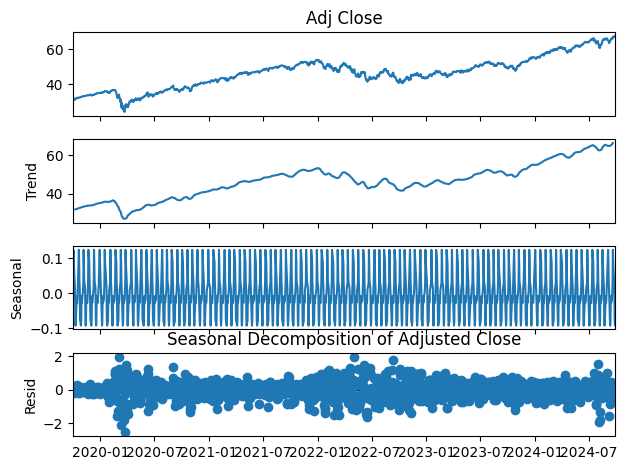

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 수정 종가에 대한 계절성 분해
result = seasonal_decompose(data['Adj Close'], model='additive', period=12)  # period는 월 단위로 설정

# 결과 시각화
result.plot()
plt.title('Seasonal Decomposition of Adjusted Close')
plt.show()

2.8 위 결과를 해석하세요.

수정 종가의 시계열 데이터는 전체적으로 상승하는 경향을 보입니다. 이 데이터는 주가이므로, 시간에 따라 경제적 요인이나 시장의 변화에 영향을 받을 수 있습니다.

추세 그래프는 전체적인 상승 경향을 보여줍니다. 이는 시간이 지남에 따라 주가가 상승하는 경향을 나타냅니다.

계절성 그래프는 주기적으로 반복되는 패턴을 보여줍니다. 특정 기간마다 일정한 주기로 나타나는 변동이 보입니다.

잔차 그래프는 추세와 계절성을 제거한 후 남은 불규칙한 변동을 나타냅니다. 이 데이터는 평균값을 중심으로 분포하고 있으며, 특정 패턴 없이 무작위로 보입니다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

차분은 현재 시점의 값에서 이전 시점의 값을 빼는 작업입니다. 즉, ( y_t - y_{t-1} )로 표현할 수 있으며, 여기서 ( y_t )는 시점 ( t )의 값입니다

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [21]:
# 1차 차분 수행
data['Adj Close Differenced'] = data['Adj Close'].diff()

# ADF 검정 수행 및 결과 출력
dftest = adfuller(data['Adj Close Differenced'].dropna(), autolag='AIC')

# ADF Statistic과 p-value만 출력
adf_statistic = dftest[0]
p_value = dftest[1]

print(f'ADF Statistic (Differenced): {adf_statistic}')
print(f'p-value (Differenced): {p_value}')

ADF Statistic (Differenced): -10.933623244940252
p-value (Differenced): 9.682823933655011e-20


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

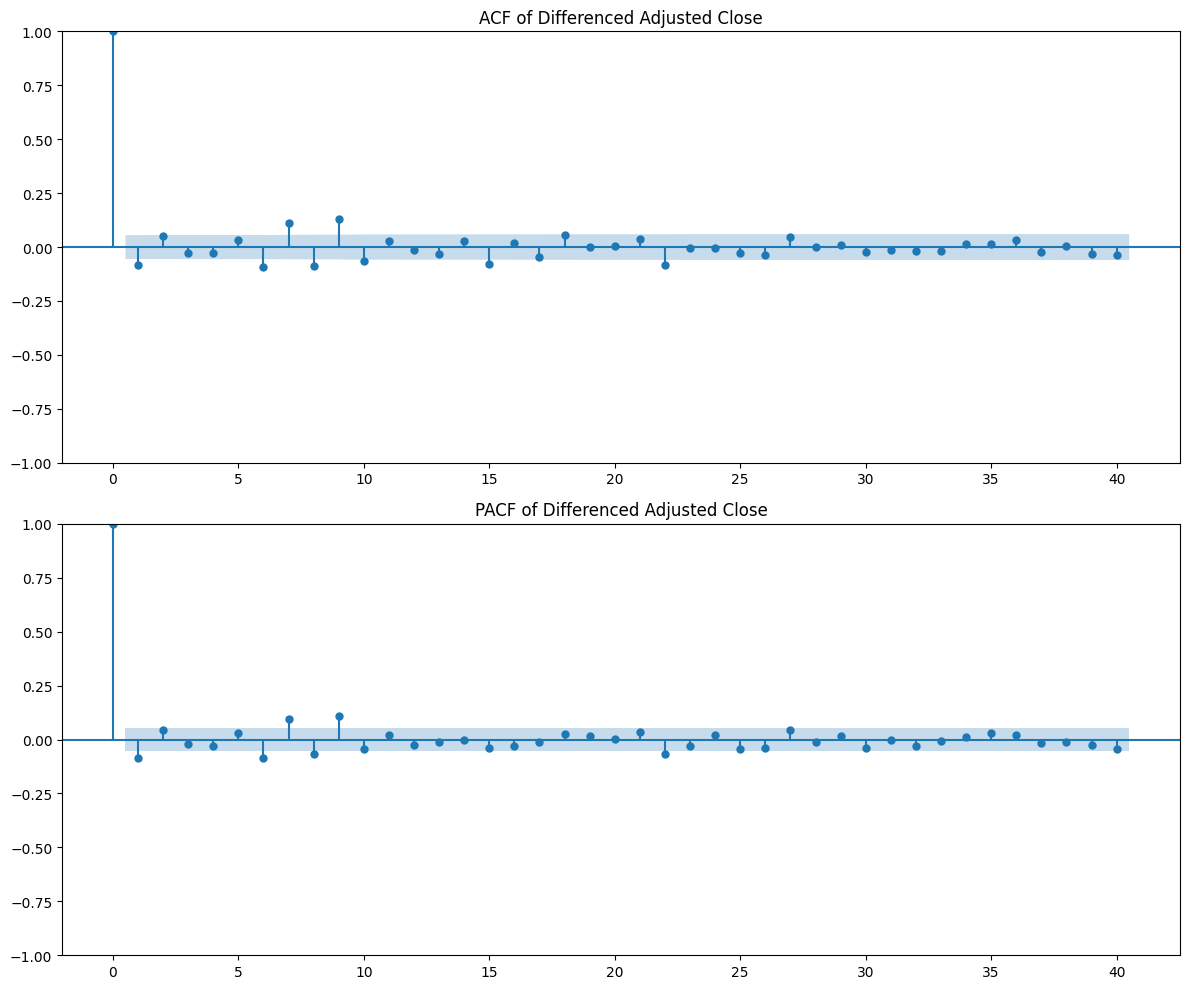

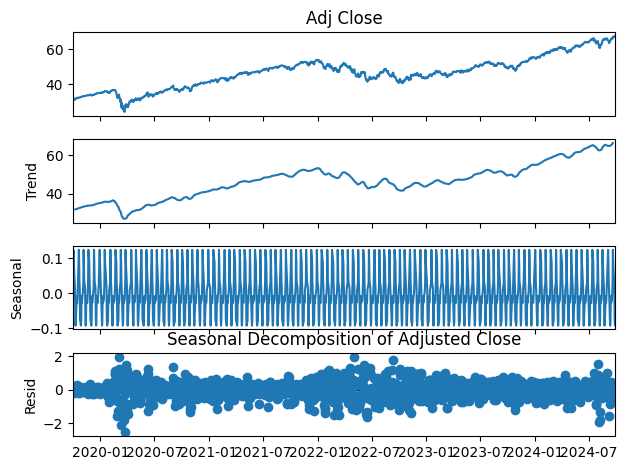

In [22]:
# ACF와 PACF 그래프 그리기
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# ACF 그래프
plot_acf(data['Adj Close Differenced'].dropna(), lags=40, ax=ax[0])
ax[0].set_title('ACF of Differenced Adjusted Close')

# PACF 그래프
plot_pacf(data['Adj Close Differenced'].dropna(), lags=40, ax=ax[1])
ax[1].set_title('PACF of Differenced Adjusted Close')

plt.tight_layout()
plt.show()

# 계절성 분해
result = seasonal_decompose(data['Adj Close'].dropna(), model='additive', period=12)  # period는 월 단위로 설정

# 결과 시각화
result.plot()
plt.title('Seasonal Decomposition of Adjusted Close')
plt.show()

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
data['Adj Close Differenced']

,Adj Close Differenced
Date,
2019-10-01,NaN
2019-10-02,-0.544416
2019-10-03,0.258369
2019-10-04,0.442896
2019-10-07,-0.147635
...,...
2024-09-23,0.175995
2024-09-24,0.190002
2024-09-25,-0.150002


In [25]:
model = ARIMA(data['Adj Close Differenced'], order=(3, 0, 0))  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()


model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     Adj Close Differenced   No. Observations:                 1257
Model:                    ARIMA(3, 0, 0)   Log Likelihood                -984.958
Date:                   Tue, 08 Oct 2024   AIC                           1979.917
Time:                           04:39:18   BIC                           2005.599
Sample:                                0   HQIC                          1989.569
                                  - 1257                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0283      0.015      1.846      0.065      -0.002       0.058
ar.L1         -0.0792      0.018     -4.349      0.000      -0.115      -0.044
ar.L2          0.0434      0.018      2.456      0.014       0.009       0.078
ar.L3         -0.0188      0.018     -1.034      0.301      -0.054       0.017
sigma2         0.2810      0.007     38.422      0.000       0.267       0.295
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               759.12
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


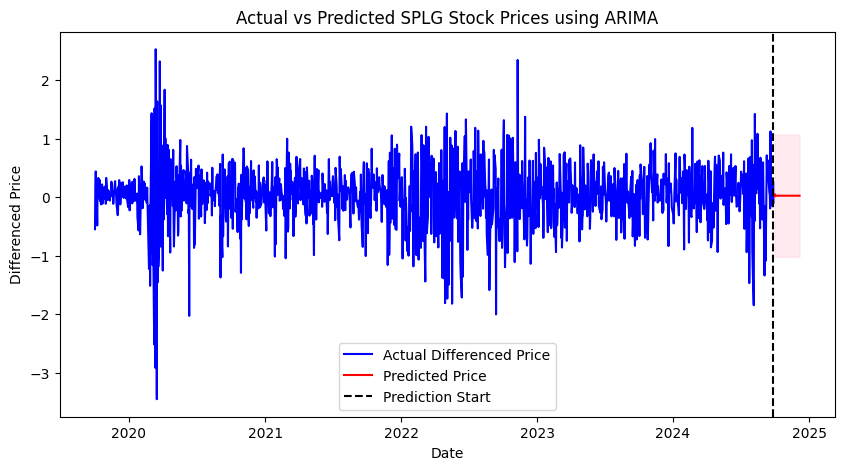

In [28]:
# 예측 수행 (50일)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['Adj Close Differenced'], label='Actual Differenced Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted SPLG Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()

In [32]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2020-01-01', end='2024-09-30')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%***********************]  1 of 1 completed


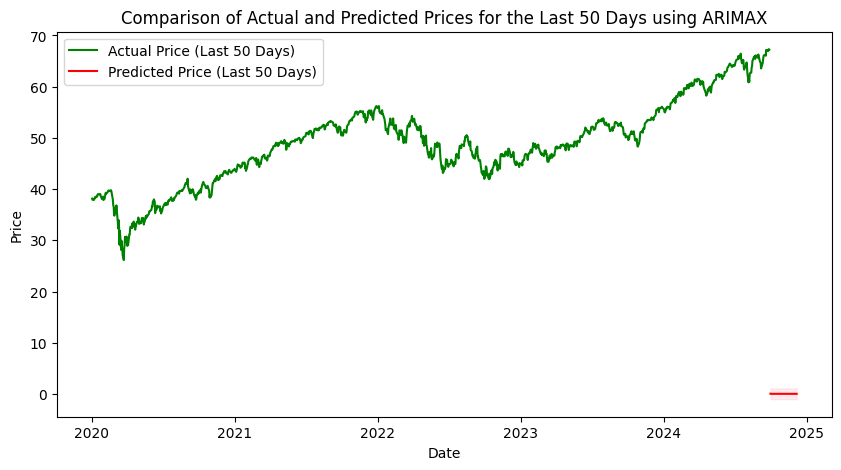

In [33]:
# 실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMAX')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [34]:
from prophet import Prophet

In [35]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'SPLG'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%***********************]  1 of 1 completed


In [36]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphqb02j2t/_ylld014.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphqb02j2t/opiluyeo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13405', 'data', 'file=/tmp/tmphqb02j2t/_ylld014.json', 'init=/tmp/tmphqb02j2t/opiluyeo.json', 'output', 'file=/tmp/tmphqb02j2t/prophet_model6nnui1pc/prophet_model-20241008045031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:50:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:50:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [37]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

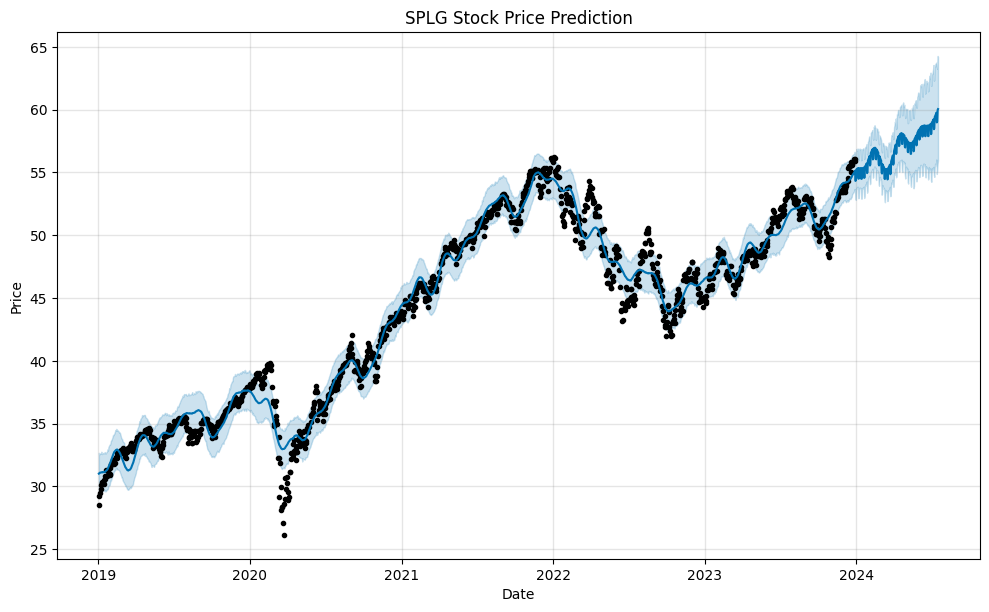

In [38]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('SPLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

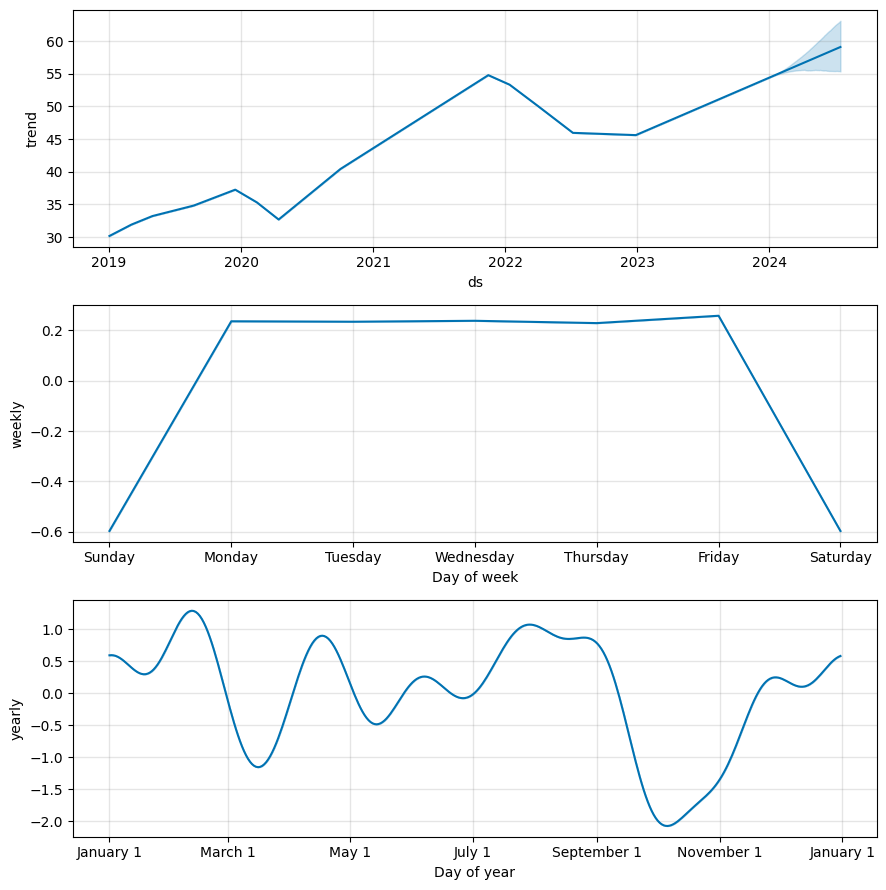

In [39]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [40]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%***********************]  1 of 1 completed


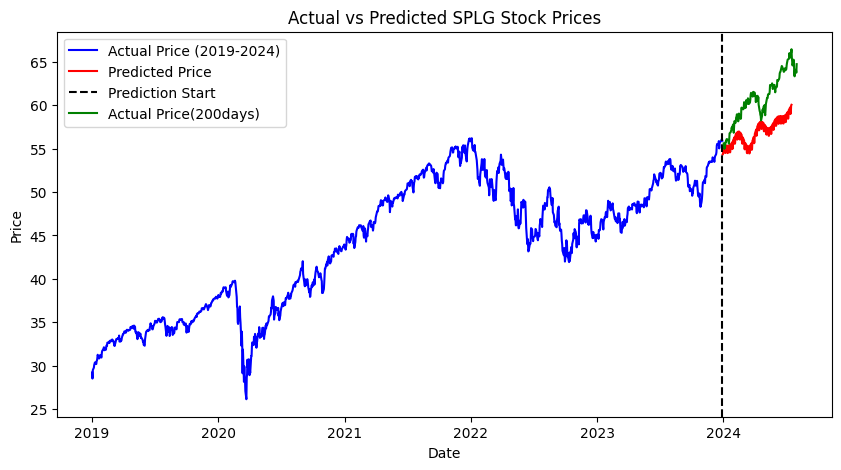

In [41]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted SPLG Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다.

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다.

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.